In [ ]:
!pip install numpy
!pip install pandas
!pip install pandasql
!pip install hopsworks

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=f5057ef1768f6602d40264d8619c9478abea2f619d16ac80e95b1256f4e245e0
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import json
import os
import re
import time
import requests
import math
import joblib
import pandasql
import hopsworks
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# Insert here your hopsworks_api_key
hopsworks_api_key = 'YOUR_HOPSWORKS_API_KEY'


project = hopsworks.login(api_key_value = hopsworks_api_key)
fs = project.get_feature_store()

fg = fs.get_feature_group(
        name="flight_weather",
        version=1,
    )

df = fg.read(dataframe_type = 'pandas')

In [ ]:
# Due to a not optimal flight API, some data as "DepApGate", "TimeTrip" cannot be calculated in new data
# Furthermore, the following columns are dropped:
df.drop(columns={'trip_time', 'dep_ap_gate'}, inplace = True)

# Due to a disproportion between categories and flights features (too mant for too few), the future columns are dropped:
# When there will be more data, it will be interesting to add them to the model
df.drop(columns={'airline_iata_code', 'flight_iata_number', 'arr_ap_iata_code'}, inplace = True)

# Some data are used as a key, but are not made to be variables of our model, furthermore are dropped:
# If there will be data coming from different airports, it will be interesting to add 'depApIataCode' as variable.
df.drop(columns={'status','dep_ap_iata_code', 'date'}, inplace = True)

# Some data should be casted to int64
convert_column = ['pressure','total_cloud', 'high_cloud', 'medium_cloud', 'low_cloud', 'sort_prep','humidity']
for col in convert_column:
    df = df.astype({col: 'int64'})

# Remove outliners in delay (dep_delay > 120)
row_list = []
for row in range(df.shape[0]):
  if (df.at[row, 'dep_delay'] > 120):
    row_list.append(row)
df.drop(row_list, inplace = True)
df.reset_index(inplace = True)
df.drop(columns={'index'}, inplace = True)


print(df.columns)

Index(['depDelay', 'depApTerminal', 'flight_within_60min', 'time', 'month',
       'day_of_week', 'temperature', 'visibility', 'pressure', 'humidity',
       'gusts_wind', 'wind_speed', 'wind_dir', 'total_cloud', 'low_cloud',
       'medium_cloud', 'high_cloud', 'sort_prep'],
      dtype='object')


In [ ]:
########################### DATA VISUALISATION #############################
############################################################################

##### DATA DISTRIBUTION ######
fig, axes = plt.subplots(9, 2, figsize=(15, 20))
quantiles = ['25%','50%', '75%']
colors = ['green', 'red', 'blue']

# Increase vertical space between subplots
fig.subplots_adjust(hspace=0.5)

print_flight = df
for col, ax in zip(print_flight, axes.flat):

    sns.histplot(ax=ax, data=print_flight, x=print_flight[col], multiple='stack')
    desc = print_flight[col].describe()




plt.show()

'''
The visualisation of the variables distribution showed that:
- depDelay contains a small amount of outliers
- there are considerably less flight on a saturday (this might mean that on saturday there is less delay)
- during the winter months (from November to Febraury) the number of flight is 25% less than the rest of the months. No significant peaks.
- the flight time have two different peaks at 8am and 17pm. There are very few flights before 6am and after 21pm.
- almost the entirety of flights depart from Terminal 5 (this might influence, as not, the flight delay)
- the temperature is bivariate and very few times goes below -15°
- visibility has two peaks, around 50km and 80km. However, there are no outliners.
- the bin date pressure (binned from 970 and 1060 in 8 buckets), is fairly a normal distribution.
- humidity, considered in percentages, from 30% to 100%, is usally high.
- gusts_wind and wind_speed have very few times high values, but their values are still acceptable (2*IQR rule)
- the number of flights within 60min is a uniform function, with a peak in 14 and a maximum in 36
- total_cloud is not representative of any other cloud measurement, however all the cloud measurement have one or two peaks in the interval extremes
- the most present are low_cloud, followed by medium_cloud and high_cloud in last position
'''

In [ ]:
# Data can be easily visualized also with the following boxplot:
box_columns = list(df.columns)
box_columns.remove('wind_dir')
for name in box_columns:
    sns.boxplot(df[name])
    plt.xlabel(name)
    plt.show()

<Figure size 500x500 with 0 Axes>

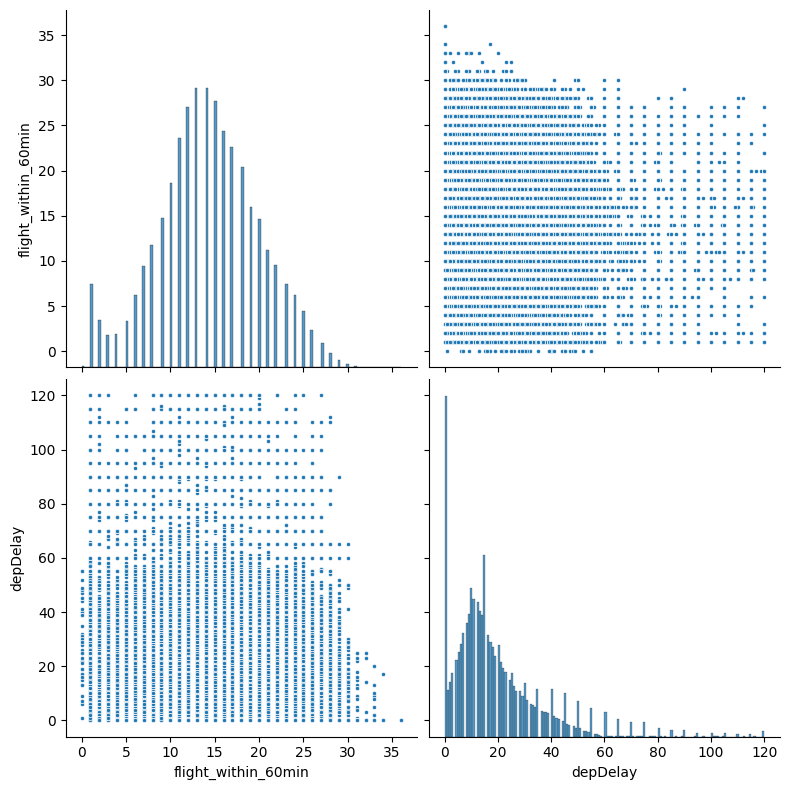

<Figure size 500x500 with 0 Axes>

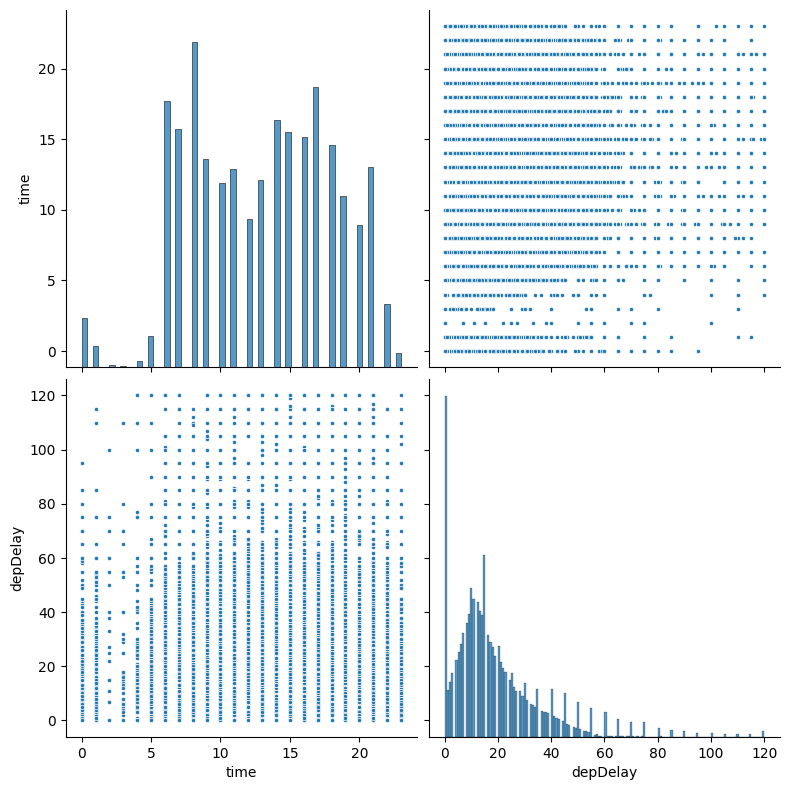

<Figure size 500x500 with 0 Axes>

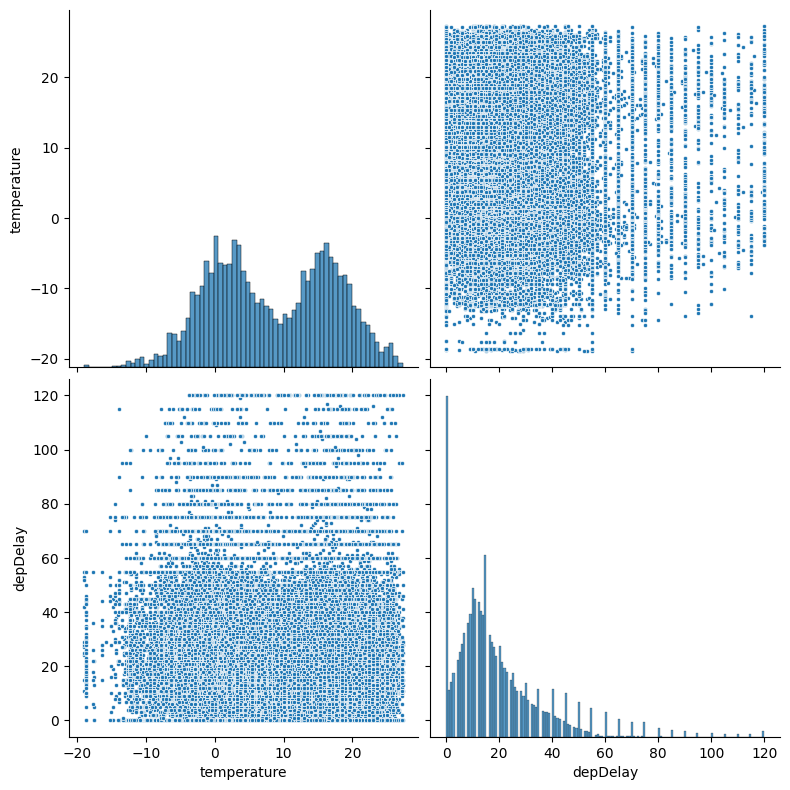

<Figure size 500x500 with 0 Axes>

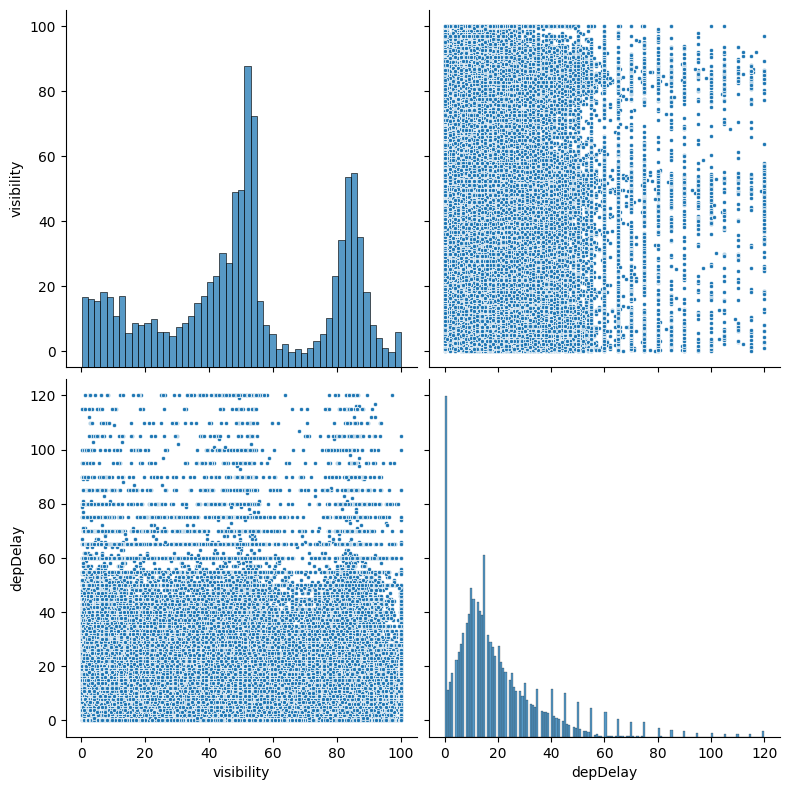

<Figure size 500x500 with 0 Axes>

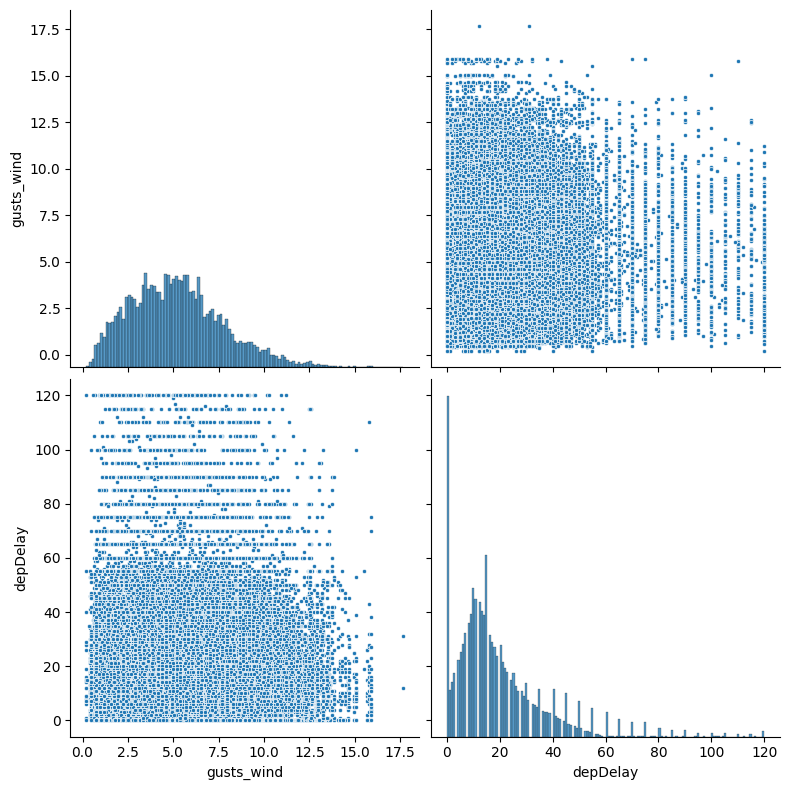

<Figure size 500x500 with 0 Axes>

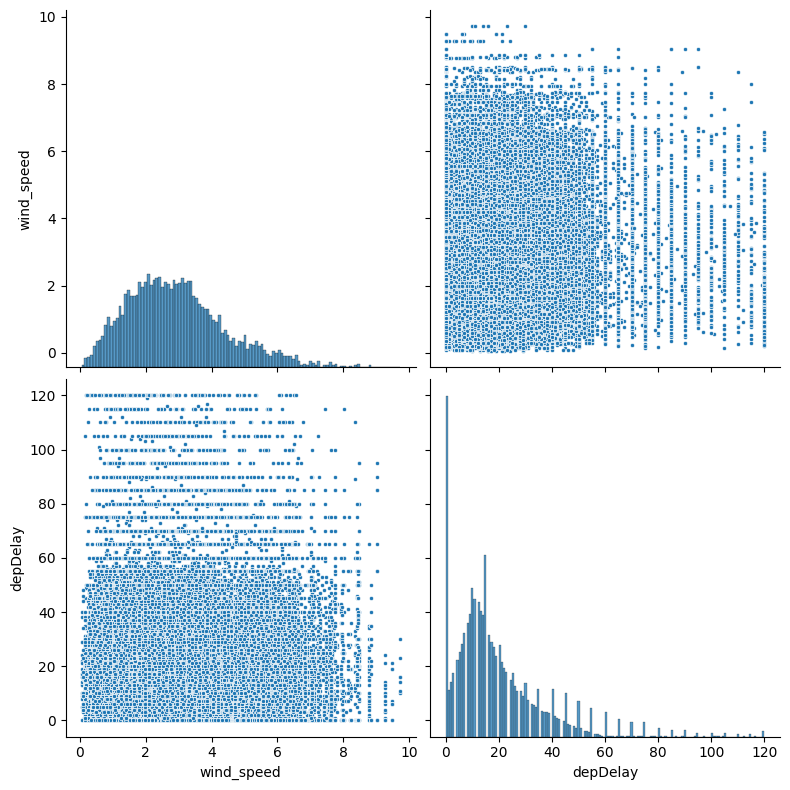

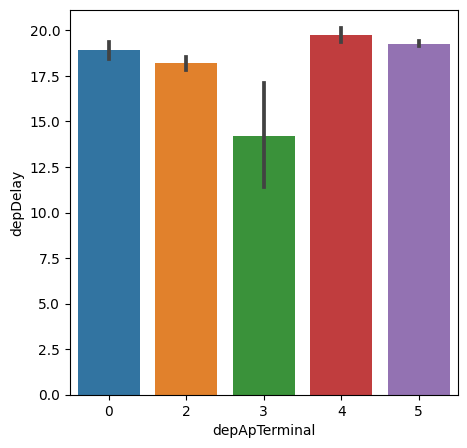

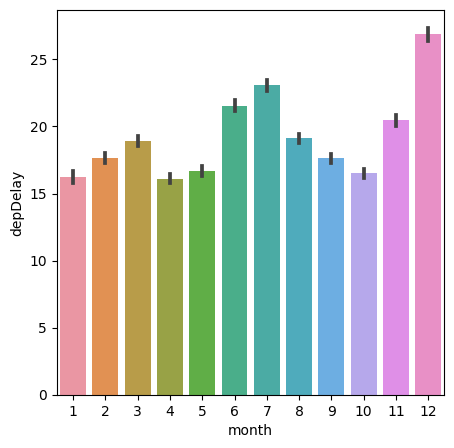

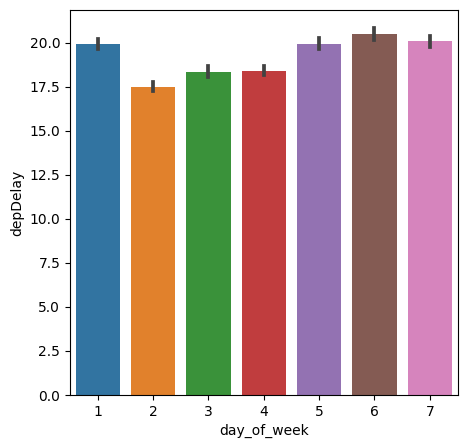

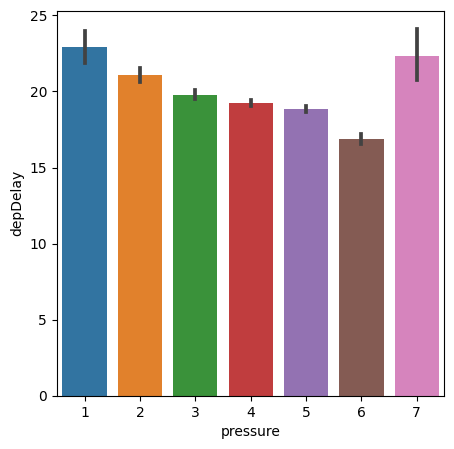

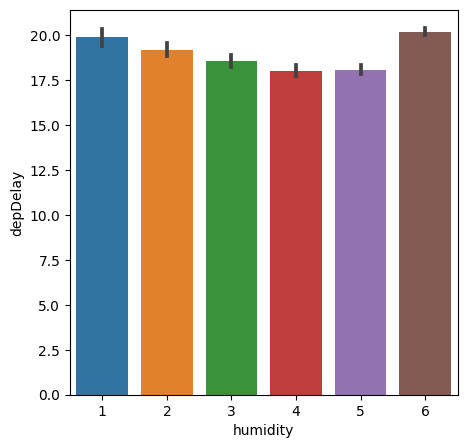

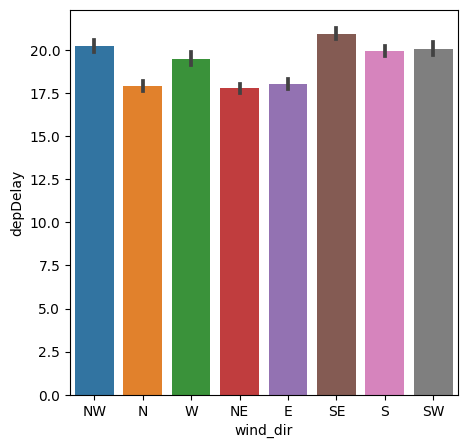

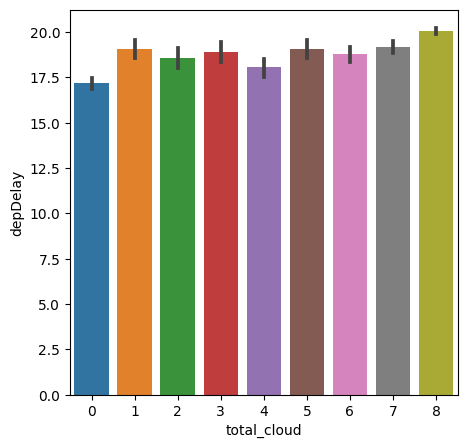

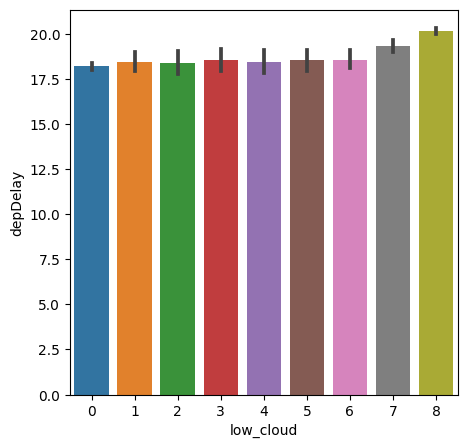

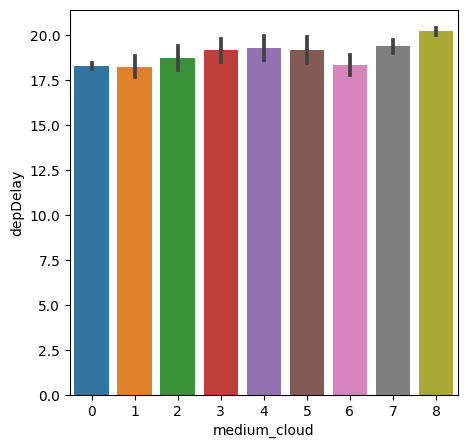

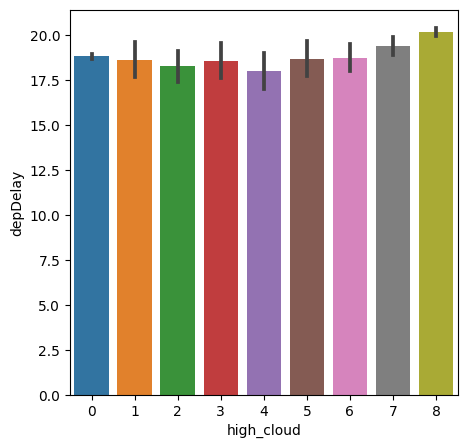

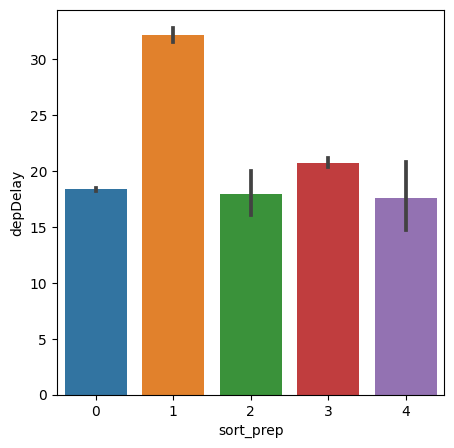

In [ ]:
numerical_elem = ['flight_within_60min', 'time', 'temperature', 'visibility', 'gusts_wind', 'wind_speed']
categorical_elem = ['dep_terminal', 'month', 'day_of_week', 'pressure', 'humidity', 'wind_dir', 'total_cloud', 'low_cloud', 'medium_cloud', 'high_cloud', 'sort_prep']

for elem in numerical_elem:
  small_df = df[[elem, 'dep_delay']]

  plt.figure(figsize=(5,5))
  g = sns.pairplot(small_df, height=4, diag_kind="hist", markers='.', corner=False)
  plt.show()

for elem in categorical_elem:
  plot = plt.figure(figsize= (5,5))
  sns.barplot(x=elem , y= 'dep_delay' , data= df)
  plt.xlabel(elem)
  plt.ylabel('dep_delay')

  plt.show()

<ipython-input-121-a4605dd69e57>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = numeric_df.corr()


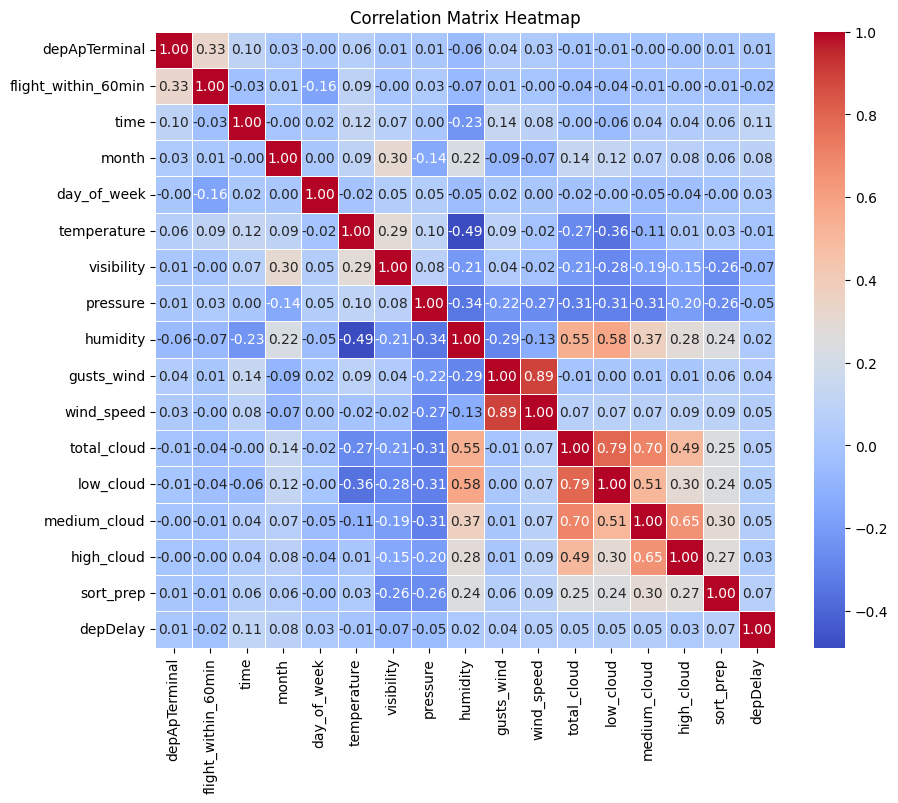

In [ ]:
# The correlation matrix is create
numeric_df = df['dep_terminal', 'flight_within_60min', 'time', 'month',
       'day_of_week', 'temperature', 'visibility', 'pressure', 'humidity',
       'gusts_wind', 'wind_speed', 'wind_dir', 'total_cloud', 'low_cloud',
       'medium_cloud', 'high_cloud', 'sort_prep', 'dep_delay']

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix Heatmap')
plt.show()